In [34]:
import sys
#!{sys.executable} -m pip install -r requirements.txt

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import cvxpy as cvx
import plotly as py
import plotly.graph_objs as go
import helper

py.offline.init_notebook_mode(connected=True)
%matplotlib inline
plt.style.use('ggplot')

## Optimization with an Alpha Model and a Risk Model
In this exercise, we will construct an optimization problem using a stock universe consisting of 3 stocks. This problem will inherently be somewhat artificial, but using a stock universe of 3 stocks will allow us to create plots in 3 dimensions. These are useful for illustrating exactly what is going on in each step and will help develop your intuition for the problem. In this exercise, we will do the following steps:
1. Create a 1-year-momentum-based alpha vector from some stock price data. 
2. Create a risk model using PCA.
3. Construct the optimization problem using the alpha vector and risk model, and apply a set of standard constraints.
4. Solve the optimization problem.


## Load the data
Load the data from the file `stock_prices_advanced_optimization.csv`.

In [36]:
prices = pd.read_csv('stock_prices_advanced_optimization.csv', parse_dates=['date'], index_col=0)

The data are the price trends for 3 stocks, Stock A, Stock B and Stock C, for 4 years, from 2013 to 2017.

In [37]:
prices.head()

,A,B,C
date,,,
2013-07-02,100.000000,102.000000,104.000000
2013-07-03,99.872139,102.298629,104.821312
2013-07-05,99.109975,102.733517,104.256297
2013-07-08,99.971278,102.877047,103.631199
2013-07-09,98.866192,102.568696,106.375325


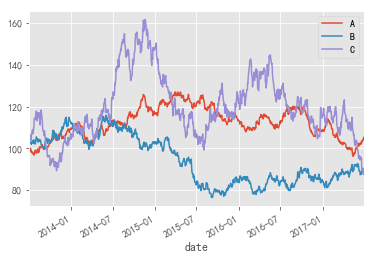

In [38]:
prices.plot()

Calculate the returns of these price data.

In [39]:
rets = prices.pct_change()[1:].fillna(0)

In [40]:
print(rets)

                   A         B         C
date                                    
2013-07-03 -0.001279  0.002928  0.007897
2013-07-05 -0.007631  0.004251 -0.005390
2013-07-08  0.008690  0.001397 -0.005996
2013-07-09 -0.011054 -0.002997  0.026480
2013-07-10 -0.005686  0.001513 -0.019092
2013-07-11  0.004004 -0.007596  0.001922
2013-07-12 -0.002213  0.005098  0.015750
2013-07-15 -0.003002  0.006473  0.021442
2013-07-16 -0.005394  0.004632  0.001115
2013-07-17  0.003620 -0.009906  0.003824
2013-07-18 -0.002317 -0.000174 -0.014258
2013-07-19 -0.005018 -0.000907 -0.004316
2013-07-22 -0.000544  0.015552  0.030043
2013-07-23 -0.004959 -0.011669  0.008415
2013-07-24  0.002706 -0.005856  0.024739
2013-07-25  0.001881  0.006061 -0.001294
2013-07-26  0.015699 -0.004553  0.004011
2013-07-29  0.001807 -0.002838  0.006315
2013-07-30  0.001920  0.013482 -0.008305
2013-07-31 -0.002186  0.005864  0.022015
2013-08-01 -0.009701  0.000952 -0.009930
2013-08-02 -0.001391  0.012132  0.021633
2013-08-05  0.00

## Create an alpha vector

In [41]:
from scipy.stats import zscore

We'll create an alpha vector based on 1-year momentum. 

In [42]:
# 1-yr momentum alpha

def log_returns(series):
    return np.log(series[-1])-np.log(series[0])
    
alpha = prices.rolling(window=252).apply(log_returns).rank(axis='columns').apply(zscore, axis='columns')

Now we'll take the row of most recent alpha values to use as our alpha vector. There should be a value in the vector for each stock.

In [43]:
# Take most recent set of values
alpha_vector = alpha.iloc[-1,:]
print(alpha_vector)
print(alpha)

A    0.000000
B    1.224745
C   -1.224745
Name: 2017-06-30 00:00:00, dtype: float64
              A         B         C
date                               
2013-07-02  NaN       NaN       NaN
2013-07-03  NaN       NaN       NaN
2013-07-05  NaN       NaN       NaN
2013-07-08  NaN       NaN       NaN
2013-07-09  NaN       NaN       NaN
2013-07-10  NaN       NaN       NaN
2013-07-11  NaN       NaN       NaN
2013-07-12  NaN       NaN       NaN
2013-07-15  NaN       NaN       NaN
2013-07-16  NaN       NaN       NaN
2013-07-17  NaN       NaN       NaN
2013-07-18  NaN       NaN       NaN
2013-07-19  NaN       NaN       NaN
2013-07-22  NaN       NaN       NaN
2013-07-23  NaN       NaN       NaN
2013-07-24  NaN       NaN       NaN
2013-07-25  NaN       NaN       NaN
2013-07-26  NaN       NaN       NaN
2013-07-29  NaN       NaN       NaN
2013-07-30  NaN       NaN       NaN
2013-07-31  NaN       NaN       NaN
2013-08-01  NaN       NaN       NaN
2013-08-02  NaN       NaN       NaN
2013-08-05  NaN 

For this problem, we'll use the optimization objective $-\boldsymbol{\alpha}^T \mathbf{x}$. Remember, we are trying to _minimize_ this function (to maximize alpha). Let's plot $-\boldsymbol{\alpha}^T \mathbf{x}$ as a function of the components of $\mathbf{x}$ so that we can get a better sense of the "shape" of the function.

In [30]:
n = 10
x = y = z = np.linspace(-2,2,n)

xv, yv, zv = np.meshgrid(x, y, z, indexing='ij')
obj_val = np.full(xv.shape, np.nan)

for i in range(n):
    for j in range(n):
        for k in range(n):
            obj_val[i,j,k] = -alpha_vector[0]*xv[i,j,k]-alpha_vector[1]*yv[i,j,k]-alpha_vector[2]*zv[i,j,k]
#print(obj_val)

In [ ]:
hover_text = helper.generate_hover_text(xv, yv, zv, 'Weight on Stock A', 'Weight on Stock B', 'Weight on Stock C', fcn_values=obj_val, fcn_label='Objective Function')

trace1 = go.Scatter3d(
    x=xv.flatten(),
    y=yv.flatten(),
    z=zv.flatten(),
    text = hover_text.flatten(),
    mode='markers',
    marker=dict(
        size=4,
        color=obj_val.flatten(),     # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        colorbar=dict(
                title='Objective Function'
            ),
        opacity=0.4,
        showscale=True
    ),
    hoverinfo = 'text'
)

data = [trace1]
layout = helper.create_standard_layout('Alpha Vector Optimization Objective Function', 'Weight on')
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In this plot, the value of the objective function is represented by the color at each point in weight space. Notice that the function increases with weight on Stock C, decreases with weight on Stock B, and doesn't depend on the weight on Stock A.

What happens if we try to run the optimization now, by trying to minimize this objective function, under no constraints?

In [44]:
def find_optimal_holdings(alpha_vector):
    """
    Use cvxpy to construct and solve an optimization problem. Use -alpha*x as the objective, and use no constraints.

    Parameters
    ----------
    alpha_vector : DataFrame
        The 3-stock alpha vector calculated above.

    Returns
    -------
    optimal_weights : DataFrame
        A DataFrame containing the optimal weights calculated by the optimization algorithm.
    """
    #TODO: Implement function
     # define weight vector
    x = cvx.Variable(len(alpha_vector))
    
    obj = cvx.Minimize(
                -alpha_vector.values.flatten()*x
            )
    
    constraints = [] # no constraints
    
    prob = cvx.Problem(obj, constraints)
    prob.solve(verbose=True, max_iters=500)

    optimal_weights = np.asarray(x.value).flatten()

    return pd.DataFrame(data=optimal_weights)

In [45]:
optimal_weights = find_optimal_holdings(
    alpha_vector
)
print("Optimal weights: ", optimal_weights)

TypeError: 'max_iters' is an invalid keyword argument for this function

As expected, without constraints, the problem is unbounded. We could achieve a smaller and smaller objective function value by taking larger and larger long positions on Stock C, and larger and larger short positions on Stock B. But this would increase risk and leverage. This is where our constraints come into play.

## Create a Risk Model

We are going to create a PCA-based risk model for our 3 stocks. First, let's plot the returns data and their mean, just to have a sense for the shape of the data.

In [ ]:
m = rets.mean()

In [ ]:
# Trace for mean return vector m
mean_vec = np.vstack((np.full(3, 0), m.values)).T

hover_text2 = helper.generate_hover_text(mean_vec[0], mean_vec[1], mean_vec[2], 'Mean of Returns of Stock A', 'Mean of Returns of Stock B', 'Mean of Returns of Stock C', sig_figs = 7)

trace2 = go.Scatter3d(
    x=mean_vec[0],
    y=mean_vec[1],
    z=mean_vec[2],
    mode='lines+markers',
    marker=dict(
        size=4,
        color='red',
        opacity=0.9,
        symbol="diamond"
    ),
    name = 'mean daily return',
    text = hover_text2.flatten(),
    hoverinfo = 'text'
)


# Trace for data
hover_text3 = helper.generate_hover_text(rets['A'].values, rets['B'].values, rets['C'].values, 'Return of Stock A', 'Return of Stock B', 'Return of Stock C')

trace3 = go.Scatter3d(
    x=rets['A'].values,
    y=rets['B'].values,
    z=rets['C'].values,
    mode='markers',
    marker=dict(
        size=4,
        color='#7FB3D5',  
        opacity=0.3,
    ),
    name = 'daily returns',
    text = hover_text3.flatten(),
    hoverinfo = 'text'
)

data = [trace2, trace3]

layout = helper.create_standard_layout('Returns Data', 'Return of')
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

There are a few things to notice here. 
1. The vector of mean returns is very small compared to the volatility of the data! Admittedly, this is an artificial example with fake data, but this is also generally the case.
2. The volatility of Stock C is larger than the volatility of Stock B, which is larger than the volatility of Stock A.

Given these data, we can already set up some expectations for what the results of PCA will look like. Remember that we expect the first PC to point in the direction of maximum variability of the data. Given the volatility of Stock C, we expect the first PC to point approximately parallel to the "Stock C axis". If we get results that are very different from this, we know that something is wrong with what we are doing. Let's now run the PCA algorithm, and see what we get. 

First we'll mean-center the data.

In [ ]:
rets = rets - m

Then we'll create a class that will fit our risk model.

In [ ]:
from sklearn.decomposition import PCA

class RiskModelPCA():
    
    ANN_FACTOR = 252
    
    def __init__(self, num_factors):
        self._num_factors = num_factors
        self.num_stocks_ = None
        self.factor_betas_ = None
        self.factor_returns_ = None
        self.common_returns_ = None
        self.residuals_ = None
        self.factor_cov_matrix_ = None
        self.idio_var_matrix_ = None
        self.explained_variance_ratio_ = None

    def fit(self, returns):
        self.num_stocks_ = len(returns.columns)
        mod = PCA(n_components=self._num_factors, svd_solver='full')
        mod.fit(returns)
        
        self.factor_betas_ = pd.DataFrame(
            data=mod.components_.T,
            index=returns.columns
        )
        
        self.factor_returns_ = pd.DataFrame(
            data=mod.transform(rets),
            index=returns.index
        )
        
        self.explained_variance_ratio_ = mod.explained_variance_ratio_
        
        self.common_returns_ = pd.DataFrame(
            data=np.dot(self.factor_returns_, self.factor_betas_.T),
            index=returns.index
        )
        self.common_returns_.columns = returns.columns
        
        self.residuals_ = (returns - self.common_returns_)
        
        self.factor_cov_matrix_ = np.diag(
            self.factor_returns_.var(axis=0, ddof=1)*RiskModelPCA.ANN_FACTOR
        )
        
        self.idio_var_matrix_ = pd.DataFrame(
            data=np.diag(np.var(self.residuals_))*RiskModelPCA.ANN_FACTOR,
            index=returns.columns
        )
        
        self.idio_var_vector_ = pd.DataFrame(
            data=np.diag(self.idio_var_matrix_.values),
            index=returns.columns
        )
        
        self.idio_var_matrix_.columns = index=returns.columns

    def get_factor_exposures(self, weights):
        B = self.factor_betas_.loc[weights.index]
        return B.T.dot(weights)

Let's fit the risk model with 2 factors (i.e., we'll keep 2 PCs).

In [ ]:
rm = RiskModelPCA(2) # create an instance of the class with 2 factors
rm.fit(rets) # fit the model on our data

Let's look at the factors (PCs).

In [ ]:
rm.factor_betas_

The first PC points almost completely in the "Stock C" direction. The second points almost completely in the "Stock B" direction. This makes sense given the fact that we see most variability in the "Stock C" direction, and if we collapse that variability, we'd see the next most variability in the "Stock B" direction. Let's plot the PC vectors to make this more clear.

In [ ]:
PC_scaler = 0.04 # The PC vectors have length 1, but this is larger than the scale of our data, so for visualization purposes, let's plot scaled-down versions of the PCs. 

# Trace for PC 0
pc0 = np.vstack((np.full(3, 0), rm.factor_betas_[0].values)).T*PC_scaler

hover_text4 = helper.generate_hover_text(pc0[0], pc0[1], pc0[2], 'Return of Stock A', 'Return of Stock B', 'Return of Stock C')

trace4 = go.Scatter3d(
    x=pc0[0],
    y=pc0[1],
    z=pc0[2],
    mode='lines+markers',
    marker=dict(
        size=4,
        color='#45B39D',
        opacity=0.9,
        symbol="diamond"
    ),
    line=dict(
        color='#45B39D',
        width=3
    ),
    name = 'PC 0',
    text = hover_text4.flatten(),
    hoverinfo = 'text'

)

# Trace for PC 1
pc1 = np.vstack((np.full(3, 0), rm.factor_betas_[1].values)).T*PC_scaler

hover_text5 = helper.generate_hover_text(pc1[0], pc1[1], pc1[2], 'Return of Stock A', 'Return of Stock B', 'Return of Stock C')

trace5 = go.Scatter3d(
    x=pc1[0],
    y=pc1[1],
    z=pc1[2],
    mode='lines+markers',
    marker=dict(
        size=4,
        color='#FFC300',
        opacity=0.9,
        symbol="diamond"
    ),
    line=dict(
        color='#FFC300',
        width=3
    ),
    name = 'PC 1',
    text = hover_text5.flatten(),
    hoverinfo = 'text'

)

# Trace for data
hover_text6 = helper.generate_hover_text(rets['A'].values, rets['B'].values, rets['C'].values, 'Return of Stock A', 'Return of Stock B', 'Return of Stock C')

trace6 = go.Scatter3d(
    x=rets['A'].values,
    y=rets['B'].values,
    z=rets['C'].values,
    mode='markers',
    marker=dict(
        size=4,
        color='#7FB3D5', 
        opacity=0.3,
    ),
    name = 'daily returns',
    text = hover_text6.flatten(),
    hoverinfo = 'text'
)

data = [trace4, trace5, trace6]

layout = helper.create_standard_layout('Returns Data with Factor (PC) Directions', 'Return of')
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

Let's look at the fraction of variance explained by the two factors we kept. This should confirm our intuition about the relative scale of variance explained by the first two factors.

In [ ]:
plt.bar(np.arange(2), rm.explained_variance_ratio_, color=['#45B39D', '#FFC300']);
plt.title('% of Variance Explained by Each Factor');

Now let's look at the factor returns. We'll convert them to "price series" and visualize the evolution of these over time. Recall that these are the data expressed in the "factor" (PC) basis––the projections of the data vectors onto the factor dimensions.

In [ ]:
(rm.factor_returns_ + 1).cumprod().plot(color=['#45B39D', '#FFC300'])

Note that in this example, since the first factor is so close to the direction of the return on Stock C, the factor return (converted to a "price series") for factor 0 looks a lot like the price evolution of Stock C, but _inverted_. This is because the PCs are vectors that represent _directions_ in space—they are only unique up to a sign change, and thus the projections onto them are unique up to a sign change.

In [ ]:
prices.plot()

## Create Optimization Constraints
As we saw above, we need to constrain our optimization problem. Let's now create and plot the following constraints:
* risk, based on our risk model
* leverage
* market neutral
* factor exposure limits
* individual weight limits

#### Risk

In [ ]:
B = rm.factor_betas_
F = rm.factor_cov_matrix_
S = np.diag(rm.idio_var_vector_.values.flatten())

Using the $\mathbf{B}$, $\mathbf{F}$, and $\mathbf{S}$ matrices, let's write a function that takes in the portfolio weights and spits out the portfolio risk. Remember that the portfolio risk is calculated $\mathbf{x}^T(\mathbf{B}^T\mathbf{F}\mathbf{B} + \mathbf{S})\mathbf{x}$, but be careful to ensure the matrices are all oriented correctly.

In [ ]:
def risk_fcn(x):
    """
    Calculate portfolio risk.

    Parameters
    ----------
    x : numpy array
        The vector of portfolio weights.

    Returns
    -------
    risk : float
        Portfolio risk.
    """
    #TODO: Implement function
    
    return None

In [ ]:
n_samples = 25
grid_max = 2.5
risk_grid, spacing, xv, yv, zv = helper.evaluate_fcn_on_grid(grid_max, n_samples, risk_fcn)

Now let's look at a plot of the value of the portfolio risk as a function of the portfolio weights in 3 dimensions.

In [ ]:
hover_text = helper.generate_hover_text(xv, yv, zv, 'Weight on Stock A', 'Weight on Stock B', 'Weight on Stock C', fcn_values=risk_grid, fcn_label='Portfolio Risk')

trace7 = go.Scatter3d(
    x=xv.flatten(),
    y=yv.flatten(),
    z=zv.flatten(),
    mode='markers',
    marker=dict(
        size=4,
        color=risk_grid.flatten(), 
        colorscale='Viridis',
        opacity=0.3,
        showscale=True
    ),
    text = hover_text.flatten(),
    hoverinfo = 'text'
)

data = [trace7]
layout = helper.create_standard_layout('Portfolio Risk as Modeled by our PCA Risk Model', 'Weight on')
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

This plot uses a color at several points in 3-D space to represent the portfolio risk as a function of weight on each stock. Note that it increases with weight on each stock. This helps us visualize the risk function, but what does it look like to _constrain_ risk? Let's visualize the boundary of the region within which risk is below a limiting value. This will help us visualize the shape of the space we search with optimization. We will do this for each of our constraints.

In [ ]:
risk_data = helper.plot_iso_surface(risk_grid, 0.05, 25, 2.5, "Portfolio Risk = 0.05", '#F5B7B1', True)

#### Leverage

Now let's write a function that takes in the portfolio weights and spits out the portfolio leverage, $\sum_i|x_i|$. This will allow us to visualize the space that satisfies the constraint $\sum_i|x_i| \leq 1$.

In [ ]:
def lev_fcn(x):
    """
    Calculate portfolio leverage.

    Parameters
    ----------
    x : numpy array
        The vector of portfolio weights.

    Returns
    -------
    leverage : float
        Portfolio risk.
    """
    #TODO: Implement function
    
    return None

n_samples = 25
grid_max = 2.5

lev_grid, _, _, _, _ = helper.evaluate_fcn_on_grid(grid_max, n_samples, lev_fcn)
lev_data = helper.plot_iso_surface(lev_grid, 1.0, n_samples, grid_max, "Leverage Ratio = 1", '#1F618D', True)

#### Market Neutral

For the market neutral constraint, we constrain the sum of the weights. Let's write a function that calculates this quantity, given the portfolio weights. Then we can visualize the plane $\sum_i x_i = 0$.

In [ ]:
def mn_fcn(x):
    """
    Calculate the sum of the portfolio weights.

    Parameters
    ----------
    x : numpy array
        The vector of portfolio weights.

    Returns
    -------
    sum_of_weights : float
        Sum of the portfolio weights.
    """
    #TODO: Implement function
    
    return None

n_samples = 25
grid_max = 2.5

mn_grid, _, _, _, _ = helper.evaluate_fcn_on_grid(grid_max, n_samples, mn_fcn)
mn_data = helper.plot_iso_surface(mn_grid, 0, n_samples, grid_max, "Sum of Weights = 0", '#D35400', True)

#### Factor Exposures

Let's also calculate the factor exposures. Then we'll plot the planes defined by the factor exposure limits. The optimization will constrain the solution to lie between each pair of planes. We'll constrain each factor exposure to be between -0.1 and 0.1.

In [ ]:
def fac_fcn(x):
    """
    Calculate portfolio factor exposures.

    Parameters
    ----------
    x : numpy array
        The vector of portfolio weights.

    Returns
    -------
    fac_exposures : numpy array
        Portfolio factor exposures.
    """
    #TODO: Implement function
    
    return None

grid_max = 2.5
n_samples = 25

fac_grid, spacing, _, _, _ = helper.evaluate_fcn_on_grid(grid_max, n_samples, fac_fcn)

factor_limit_data = []

for factor in range(B.shape[1]):
    for l in range(2):
        mult_fac = l*2-1
        factor_limit_data.extend(helper.plot_iso_surface(fac_grid[:,:,:,factor], 0.1*mult_fac, n_samples, grid_max, 'Factor Exposure Limits', '#D2B4DE', False))

layout = helper.create_standard_layout('Factor Exposure Limits', 'Weight on')

fig = go.Figure(data=factor_limit_data, layout=layout)         
        
py.offline.iplot(fig)

#### Individual Weight Limits

Finally, let's look at the space inside the constraints on each individual weight. We'll constrain each individual weight to be between -0.55 and 0.55.

In [ ]:
x_max = 0.55

x = np.array([-1, -1, 1, 1, -1, -1, 1, 1])*x_max
y = np.array([-1, 1, 1, -1, -1, 1, 1, -1])*x_max
z = np.array([-1, -1, -1, -1, 1, 1, 1, 1])*x_max
hover_text = helper.generate_hover_text(x, y, z, 'Weight on Stock A', 'Weight on Stock B', 'Weight on Stock C')


weight_data = [
    go.Mesh3d(
        x = x,
        y = y,
        z = z,
        colorscale = '#FCF3CF',
        intensity = np.full(8, 1),
        i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
        j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
        k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
        name='Weight on Stock B',
        showscale=False,
        opacity = 0.3,
        hoverinfo='none'
    )
]

trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=6,
        opacity=0.0001,
        color='#BFB1A8', 
    ),
    text = hover_text.flatten(),
    hoverinfo = 'text',
    showlegend=False
)
    
weight_data = [weight_data[0], trace]    
    
layout = helper.create_standard_layout('Individual Weight Limits', 'Weight on')
fig = go.Figure(data=weight_data, layout=layout)
py.offline.iplot(fig)

#### Plot all the constraints on the same axes

Finally, let's visualize the space that satisfies all the constraints. It has to be inside all of the enclosed spaces, _on_ the plane defined by the market neutral constraint, and _between_ the planes defined by the factor exposure constraints.

In [ ]:
data = risk_data
data.extend(lev_data)
data.extend(mn_data)
data.extend(factor_limit_data)
data.extend(weight_data)
layout = helper.create_standard_layout('Visualize Intersection of All Constraints', 'Weight on')
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

## Optimization
Finally, let's define and run the optimization problem with the same objective function as above, but this time, with all the constraints we just discussed. Remember that the optimization is looking for the point in the space that satisfies all the constraints that _minimizes_ the alpha function.

In [ ]:
def find_optimal_holdings(
    alpha_vector,
    risk_model,
    risk_cap=0.05,
    factor_max=10.0,
    factor_min=-10.0,
    x_max=0.55,
    x_min=-0.55):
    
    """
    Define an optimization problem. It takes in several inputs and optimization parameters and outputs the
    optimized weights. The objective should minimize the objective -alpha*x, but also apply the risk, leverage,
    market neutral, factor exposure, and invidiual weight constraints.

    Parameters
    ----------
    alpha_vector : numpy array
        The alpha vector used in the optimization objective.
    risk_model : RiskModelPCA
        The risk model calculated above using PCA.
    risk_cap : float
        The limit to be placed on portfolio risk.
    factor_max : float
        The factor exposure upper limit.
    factor_min : float
        The factor exposure lower limit.
    x_max : float
        The individual weight upper limit.
    x_min : float
        The individual weight lower limit.

    Returns
    -------
    optimal_weights : numpy array
        The optimal portfolio weights.
    """
    #TODO: Implement function
    
    return None

In [ ]:
optimal_weights = find_optimal_holdings(
    alpha_vector,
    rm
)

In [ ]:
optimal_weights

The optimal weights are 0 weight on Stock A, 50% long on Stock B and 50% short on Stock C.

The solution for this notebook is [here](Advanced_Opt_solution.ipynb).